<a href="https://colab.research.google.com/github/CodeWithSridhar/Innomatics-Internship/blob/main/Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hackathon on FIFA Football Dataset**


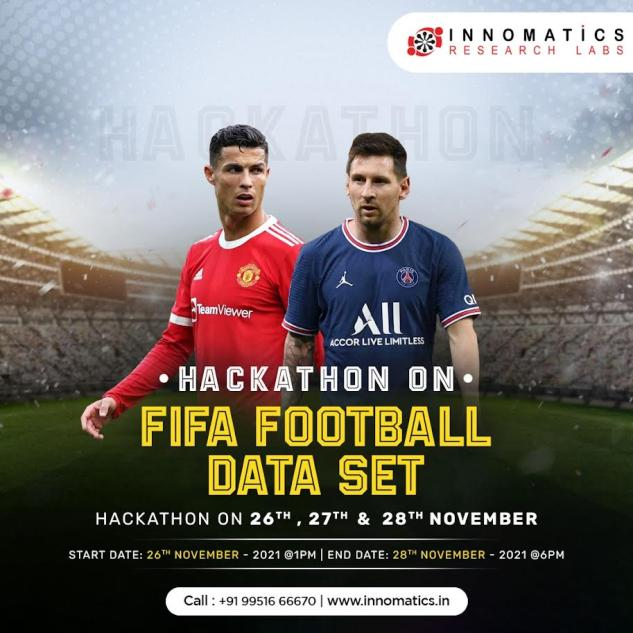






Dataset link: https://drive.google.com/file/d/1xoCpTxZNeiibUvPvMDWggPpbDcvYz-xk/view?usp=sharing 

# About the Dataset
This dataset contains features of around 18,000 football players. You are expected to complete the following tasks. Use only numerical attributes to cluster the data.


**Task 1** - Data Visualization and Data Preparation
You can use matplotlib and seaborn for visualization. This is an open ended task. For your comfort, below mentioned are the basic visualization you can start with:

    Plot histogram of count of players based on some attributes like height.
    Plot histogram and kde plots on attributes like ‘Value’ and ‘Wage’
    Use visualization techniques to find outliers like Ronaldo and Messi
    Distribution of players in different clubs/countries on the basis of some attributes
    And many more….
Try to perform below mention data transformations:

    Remove inconsistencies from ‘Value’ and ‘Wage’ columns
    Missing Values and Outliers treatment


**Task 2** - K Means

    Implement k-means clustering. Choose k = 3, 5, 7
    Use only numeric attributes to cluster
    Use elbow method and Silhouette Score to get optimal number of clusters
    Analyse the results/clusters formed(in every case above) based on the following parameters:
    How good are the clusters? Use inter and intra class similarities to measure the goodness of clusters
    Find any hidden patterns if any


**Task 3** - Hierarchical Clustering

    Cluster the data using Agglomerative method of your choice
    Plot dendrogram
    Analyse the cluster formed based on the following parameters:
    How good are the clusters? Use inter and intra class similarities to measure the goodness of clusters
    Find any hidden patterns if any

**Task 4** - DBScan

    Use DBScan to cluster the data
    DBScan requires 2 parameters - epsilon and minPts. Show all the experiments performed to arrive at the final epsilons and minPts
    Analyse the cluster formed
    How good are the clusters? Use inter and intra class similarities to measure the goodness of clusters
    Find any hidden patterns if any


In [1]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm   #for color map
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score #Know the ideal number of clusters
from collections import Counter
%matplotlib inline

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/CodeWithSridhar/Innomatics-Internship/main/football_data.csv")

In [3]:
data.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,...,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,"Jul 1, 2004",NaN,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,...,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,"Jul 10, 2018",NaN,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,...,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,"Aug 3, 2017",NaN,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,...,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,"Jul 1, 2011",NaN,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,"Aug 30, 2015",NaN,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,...,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [6]:
data.shape

(18207, 89)

In [10]:
fifa = data.copy()
fifa.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,...,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,"Jul 1, 2004",NaN,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,...,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,"Jul 10, 2018",NaN,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,...,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,"Aug 3, 2017",NaN,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,...,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,"Jul 1, 2011",NaN,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,"Aug 30, 2015",NaN,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,...,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


## Data Cleaning

In [11]:
fifa.drop(['Unnamed: 0','Photo','Flag','Club Logo','Real Face','Jersey Number','Loaned From'],
          axis=1,inplace=True)

In [12]:
fifa['Wage'].head()

0    €565K
1    €405K
2    €290K
3    €260K
4    €355K
Name: Wage, dtype: object

In [14]:
fifa['Value'].head()

0    €110.5M
1       €77M
2    €118.5M
3       €72M
4      €102M
Name: Value, dtype: object

In [15]:
# Value, Wage and Release Clause Conversion
def value_and_wage_conversion(Value):
    if isinstance(Value,str):
        out = Value.replace('€', '')
        if 'M' in out:
            out = float(out.replace('M', ''))*1000000
        elif 'K' in Value:
            out = float(out.replace('K', ''))*1000
        return float(out)

In [16]:
#value
fifa['Value'] = fifa['Value'].apply(lambda x: value_and_wage_conversion(x))

In [17]:
#wage
fifa['Wage'] = fifa['Wage'].apply(lambda x: value_and_wage_conversion(x))

In [18]:
# Release Clause
fifa['Release Clause'] = fifa['Release Clause'].apply(lambda x: value_and_wage_conversion(x))
fifa['Release Clause'].fillna(fifa['Release Clause'].mean(), inplace = True)

In [19]:
#Categorical Columns
fifa['Club'].fillna('No Club', inplace = True)
fifa['Position'].fillna('unknown',inplace=True)

In [20]:
#Joined Column
def clean_date(x):
    l=[]
    if isinstance(x,str):
        l=x.split(", ")
        x=l[-1]
    return(x)

fifa['Joined']=fifa['Joined'].replace(np.nan,0)
fifa['Joined'] = fifa['Joined'].apply(clean_date).astype('str')

In [21]:
#Contract Valid Until Column
import datetime
fifa['Contract Valid Until']=pd.to_datetime(fifa['Contract Valid Until'])
fifa['year'] = pd.DatetimeIndex(fifa['Contract Valid Until']).year.astype(str)
fifa['Contract Valid Until'].fillna('Not available', inplace = True) 

In [25]:
#Work Rate Column
fifa['Work Rate'].value_counts()

Medium/ Medium    9810
High/ Medium      3173
Medium/ High      1690
High/ High        1015
Medium/ Low        850
High/ Low          699
Low/ Medium        449
Low/ High          439
Low/ Low            34
Name: Work Rate, dtype: int64

In [26]:
#Preferred Foot column
fifa['Preferred Foot'].value_counts()

Right    13948
Left      4211
Name: Preferred Foot, dtype: int64

In [28]:
fifa['Preferred Foot'].fillna('Right', inplace = True)

In [27]:
#Body Type
fifa['Body Type'].value_counts()

Normal                 10595
Lean                    6417
Stocky                  1140
Shaqiri                    1
PLAYER_BODY_TYPE_25        1
Messi                      1
Neymar                     1
C. Ronaldo                 1
Courtois                   1
Akinfenwa                  1
Name: Body Type, dtype: int64

In [31]:
#convert skill rating at each position.
def skillConverter(val):
    if type(val) == str:
        s1 = val[0:2]
        s2 = val[-1]
        val = int(s1) + int(s2)
        return val
    else:
        return val

skill_columns = ['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM',
       'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM',
       'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB']

for col in skill_columns:
    fifa[col] = fifa[col].apply(skillConverter)
    fifa[col].fillna(0.0, inplace = True)



In [32]:
fifa.head()

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Position,Joined,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,LCM,CM,RCM,RM,LWB,LDM,CDM,...,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,year
0,158023,L. Messi,31,Argentina,94,94,FC Barcelona,110500000.0,565000.0,2202,Left,5.0,4.0,4.0,Medium/ Medium,Lean,RF,2004,2021-01-01 00:00:00,1,159.0,90.0,90.0,90.0,94.0,95.0,95.0,95.0,94.0,95.0,95.0,95.0,93.0,86.0,86.0,86.0,93.0,66.0,63.0,63.0,...,49.0,49.0,49.0,61.0,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226500000.0,2021.0
1,20801,Cristiano Ronaldo,33,Portugal,94,94,Juventus,77000000.0,405000.0,2228,Right,5.0,4.0,5.0,High/ Low,Lean,ST,2018,2022-01-01 00:00:00,1,183.0,94.0,94.0,94.0,92.0,93.0,93.0,93.0,92.0,91.0,91.0,91.0,91.0,84.0,84.0,84.0,91.0,68.0,64.0,64.0,...,56.0,56.0,56.0,64.0,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127100000.0,2022.0
2,190871,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,118500000.0,290000.0,2143,Right,5.0,5.0,5.0,High/ Medium,Lean,LW,2017,2022-01-01 00:00:00,1,150.0,87.0,87.0,87.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,92.0,91.0,84.0,84.0,84.0,91.0,68.0,63.0,63.0,...,50.0,50.0,50.0,63.0,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228100000.0,2022.0
3,193080,De Gea,27,Spain,91,93,Manchester United,72000000.0,260000.0,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,GK,2011,2020-01-01 00:00:00,1,168.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138600000.0,2020.0
4,192985,K. De Bruyne,27,Belgium,91,92,Manchester City,102000000.0,355000.0,2281,Right,4.0,5.0,4.0,High/ High,Normal,RCM,2015,2023-01-01 00:00:00,1,154.0,85.0,85.0,85.0,90.0,90.0,90.0,90.0,90.0,91.0,91.0,91.0,91.0,90.0,90.0,90.0,91.0,80.0,80.0,80.0,...,69.0,69.0,69.0,76.0,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196400000.0,2023.0


## Explorotary Data Analysis

Age distributation visualization

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


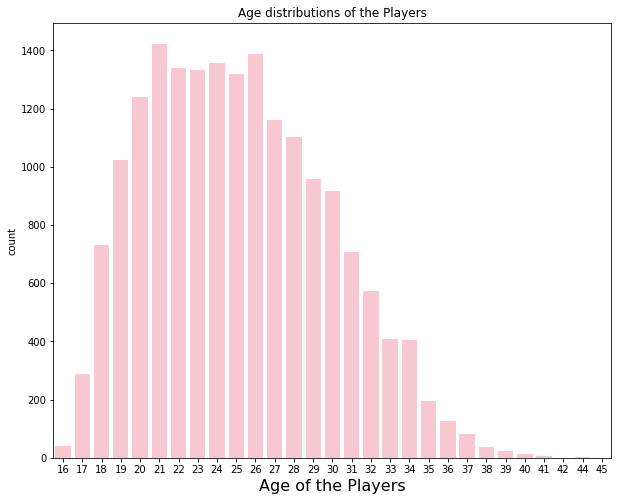

In [35]:
x = fifa['Age']
plt.figure(figsize=(10,8))
ax = sns.countplot(x,color='pink')
ax.set_xlabel(xlabel = 'Age of the Players')
ax.set_title(label = 'Age distributions of the Players')
plt.show()

Visualizing Age by Potential and Overall Ratings⚓

In [38]:
overall = pd.DataFrame(fifa.groupby(["Age"])['Overall'].mean())
potential = pd.DataFrame(fifa.groupby(["Age"])['Potential'].mean())

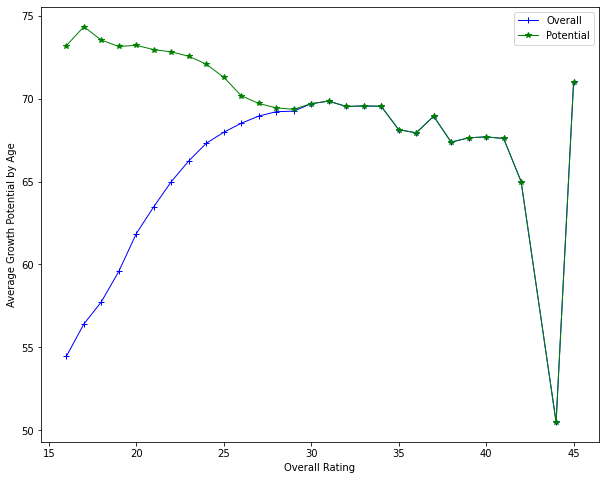

In [42]:
merged = pd.merge(overall, potential, on='Age', how='inner')
merged['Age']= merged.index

fig, ax = plt.subplots(figsize=(10,8))

merged.reset_index(drop = True, inplace = True)

plt.plot('Age', 'Overall', data=merged, marker='+', color='b', lw=1, label ="Overall" )
plt.plot('Age', 'Potential', data=merged, marker='*', color='g', lw=1, label = "Potential")
plt.xlabel('Overall Rating')
plt.ylabel('Average Growth Potential by Age')
plt.legend();

**Top features for Playing Positions:**

In [43]:
player_features = ['Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed',
       'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping',
       'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions',
       'Positioning', 'Vision', 'Penalties', 'Composure', 'Marking',
       'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes']
df_postion  = pd.DataFrame()
for position_name, features in fifa.groupby(fifa['Position'])[player_features].mean().iterrows():
    top_features = dict(features.nlargest(5))
    df_postion[position_name] = tuple(top_features)
df_postion.head()

,CAM,CB,CDM,CF,CM,GK,LAM,LB,LCB,LCM,LDM,LF,LM,LS,LW,LWB,RAM,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST,unknown
0,Balance,Strength,Stamina,Agility,Balance,GKReflexes,Agility,SprintSpeed,Strength,Stamina,Stamina,Balance,Acceleration,SprintSpeed,Acceleration,SprintSpeed,Agility,SprintSpeed,Strength,Stamina,Stamina,Agility,Acceleration,SprintSpeed,Acceleration,SprintSpeed,SprintSpeed,Balance
1,Agility,Jumping,Aggression,Balance,ShortPassing,GKDiving,Balance,Acceleration,Jumping,ShortPassing,ShortPassing,Agility,SprintSpeed,Strength,SprintSpeed,Acceleration,Balance,Stamina,Jumping,ShortPassing,ShortPassing,Acceleration,SprintSpeed,Strength,SprintSpeed,Acceleration,Strength,Agility
2,Acceleration,StandingTackle,Strength,Acceleration,Agility,GKPositioning,SprintSpeed,Stamina,StandingTackle,Balance,Strength,Acceleration,Agility,Acceleration,Agility,Stamina,Acceleration,Acceleration,Aggression,Agility,Aggression,Balance,Agility,Acceleration,Agility,Stamina,Acceleration,Acceleration
3,SprintSpeed,Aggression,ShortPassing,SprintSpeed,Stamina,GKHandling,Acceleration,Balance,Aggression,Agility,Aggression,Dribbling,Balance,ShotPower,Balance,Agility,SprintSpeed,Balance,StandingTackle,Balance,Strength,BallControl,Balance,Agility,Balance,Agility,Jumping,SprintSpeed
4,BallControl,HeadingAccuracy,Jumping,Dribbling,Acceleration,GKKicking,Dribbling,Agility,HeadingAccuracy,BallControl,BallControl,BallControl,Dribbling,Positioning,Dribbling,Balance,Dribbling,Jumping,HeadingAccuracy,BallControl,Jumping,SprintSpeed,Dribbling,ShotPower,Dribbling,Balance,Finishing,Jumping


**Team With highest player's value:**

In [48]:
import plotly.express as px
club = fifa.groupby('Club')['Value'].mean().reset_index().sort_values('Value', ascending=True).tail(20)
fig = px.bar(club, x="Value", y="Club", orientation='h')
fig.show()

From here we can conclude that the top five teams with highest players average values are Juventus, Real Madrid, FC Barcellona, Manchester city and FC Bayern Munchen.

In [49]:
# Top teams with highest Player's overall ratings
club = fifa.groupby('Club')['Overall'].mean().reset_index().sort_values('Overall', ascending=True).tail(20)
fig = px.bar(club, x="Overall", y="Club", orientation='h')
fig.show()

Juventus, Napoli, Inter, Real Madrid and milan are the top five teams with highest player's average Overall rating.

#Visualizing Technical Aspects:

In [ ]:
for i, col in enumerate(data.columns):
    print(i, col)

0 Unnamed: 0
1 ID
2 Name
3 Age
4 Photo
5 Nationality
6 Flag
7 Overall
8 Potential
9 Club
10 Club Logo
11 Value
12 Wage
13 Special
14 Preferred Foot
15 International Reputation
16 Weak Foot
17 Skill Moves
18 Work Rate
19 Body Type
20 Real Face
21 Position
22 Jersey Number
23 Joined
24 Loaned From
25 Contract Valid Until
26 Height
27 Weight
28 LS
29 ST
30 RS
31 LW
32 LF
33 CF
34 RF
35 RW
36 LAM
37 CAM
38 RAM
39 LM
40 LCM
41 CM
42 RCM
43 RM
44 LWB
45 LDM
46 CDM
47 RDM
48 RWB
49 LB
50 LCB
51 CB
52 RCB
53 RB
54 Crossing
55 Finishing
56 HeadingAccuracy
57 ShortPassing
58 Volleys
59 Dribbling
60 Curve
61 FKAccuracy
62 LongPassing
63 BallControl
64 Acceleration
65 SprintSpeed
66 Agility
67 Reactions
68 Balance
69 ShotPower
70 Jumping
71 Stamina
72 Strength
73 LongShots
74 Aggression
75 Interceptions
76 Positioning
77 Vision
78 Penalties
79 Composure
80 Marking
81 StandingTackle
82 SlidingTackle
83 GKDiving
84 GKHandling
85 GKKicking
86 GKPositioning
87 GKReflexes
88 Release Clause


Position of the players is in Row 21.

Create a new variable to get the Position, Height, Weight and all the technical characteristics. 

We will concatenate Row 21, 26, 27 with the Row 54 to 82 because all these are technical parts from a football game point of view:

In [ ]:
cols = [21, 26, 27]
cols += range(54, 83)

In [ ]:
# creating a new data frame to make the clusters of the FIFA's players
data = data.iloc[:, cols]

In [ ]:
data.head()

,Position,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,RF,5'7,159lbs,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0
1,ST,6'2,183lbs,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0
2,LW,5'9,150lbs,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0
3,GK,6'4,168lbs,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0
4,RCM,5'11,154lbs,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0


Above dataframe is the technical aspects of the football players which will help us to analyze the performance.

In [ ]:
# checking missing values:
data.isnull().sum(axis = 0)

Position           60
Height             48
Weight             48
Crossing           48
Finishing          48
HeadingAccuracy    48
ShortPassing       48
Volleys            48
Dribbling          48
Curve              48
FKAccuracy         48
LongPassing        48
BallControl        48
Acceleration       48
SprintSpeed        48
Agility            48
Reactions          48
Balance            48
ShotPower          48
Jumping            48
Stamina            48
Strength           48
LongShots          48
Aggression         48
Interceptions      48
Positioning        48
Vision             48
Penalties          48
Composure          48
Marking            48
StandingTackle     48
SlidingTackle      48
dtype: int64

Here we can see that there are total 60 missing values in Position row.

Let's check if the missing values of the others attributes have a relationship with the missing values of the Position.

In [ ]:
len(data) - len(data.dropna())

60

In [ ]:
(60 / len(data)) * 100

0.32954358213873786

60 records that doesn't have Position value, also do not have the other records. So we will delete these 60 records whose values are missing..

In [ ]:
data = data.dropna()

In [ ]:
data.isna().sum(axis = 0)

Position           0
Height             0
Weight             0
Crossing           0
Finishing          0
HeadingAccuracy    0
ShortPassing       0
Volleys            0
Dribbling          0
Curve              0
FKAccuracy         0
LongPassing        0
BallControl        0
Acceleration       0
SprintSpeed        0
Agility            0
Reactions          0
Balance            0
ShotPower          0
Jumping            0
Stamina            0
Strength           0
LongShots          0
Aggression         0
Interceptions      0
Positioning        0
Vision             0
Penalties          0
Composure          0
Marking            0
StandingTackle     0
SlidingTackle      0
dtype: int64

## Analyzing the statistics of Technical aspects

In [ ]:
def hist_boxplot(feature):
  fig, ax = plt.subplots(1, 2)
  ax[0].hist(feature)
  ax[1].boxplot(feature)

In [ ]:
data_stats = data.describe()
data_stats

,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
count,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000,18147.000000
mean,49.738414,45.550229,52.300766,58.695432,42.912217,55.375158,47.176283,42.866038,52.721386,58.374828,64.612829,64.726236,63.501295,61.839147,63.964292,55.465201,65.091034,63.221579,65.318620,47.113187,55.876068,46.702761,49.962198,53.407781,48.546371,58.651127,47.286053,47.701879,45.666336
std,18.364255,19.527445,17.381753,14.696075,17.695900,18.912224,18.396009,17.480034,15.325211,16.685643,14.930320,14.651776,14.768956,9.011056,14.136073,17.235534,11.822327,15.896381,12.552479,19.263142,17.366534,20.697462,19.530469,14.146594,15.703113,11.437138,19.900450,21.663630,21.287961
min,5.000000,2.000000,4.000000,7.000000,4.000000,4.000000,6.000000,3.000000,9.000000,5.000000,12.000000,12.000000,14.000000,21.000000,16.000000,2.000000,15.000000,12.000000,17.000000,3.000000,11.000000,3.000000,2.000000,10.000000,5.000000,3.000000,3.000000,2.000000,3.000000
25%,38.000000,30.000000,44.000000,54.000000,30.000000,49.000000,34.000000,31.000000,43.000000,54.000000,57.000000,57.000000,55.000000,56.000000,56.000000,45.000000,58.000000,56.000000,58.000000,33.000000,44.000000,26.000000,38.000000,44.000000,39.000000,51.000000,30.000000,27.000000,24.000000
50%,54.000000,49.000000,56.000000,62.000000,44.000000,61.000000,48.000000,41.000000,56.000000,63.000000,67.000000,67.000000,66.000000,62.000000,66.000000,59.000000,66.000000,66.000000,67.000000,51.000000,59.000000,52.000000,55.000000,55.000000,49.000000,60.000000,53.000000,55.000000,52.000000
75%,64.000000,62.000000,64.000000,68.000000,57.000000,68.000000,62.000000,57.000000,64.000000,69.000000,75.000000,75.000000,74.000000,68.000000,74.000000,68.000000,73.000000,74.000000,74.000000,62.000000,69.000000,64.000000,64.000000,64.000000,60.000000,67.000000,64.000000,66.000000,64.000000
max,93.000000,95.000000,94.000000,93.000000,90.000000,97.000000,94.000000,94.000000,93.000000,96.000000,97.000000,96.000000,96.000000,96.000000,96.000000,95.000000,95.000000,96.000000,97.000000,94.000000,95.000000,92.000000,95.000000,94.000000,92.000000,96.000000,94.000000,93.000000,91.000000


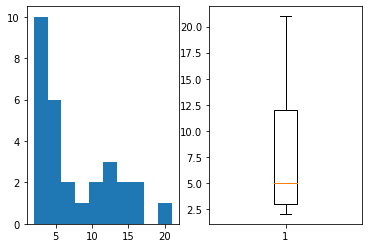

In [ ]:
hist_boxplot(data_stats.loc['min'])



As we can see, most of the minimum values are more distributed up to the value 16, 17 for example, with a large gap between the 15 and the 20. On the side graph, it is clear that the values are more concentrated in the value 5,0.


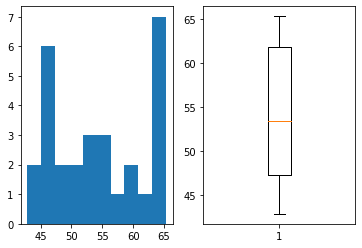

In [ ]:
hist_boxplot(data_stats.loc['mean'])

Here we see that the values are more concentrated in the range between 50 and 55.

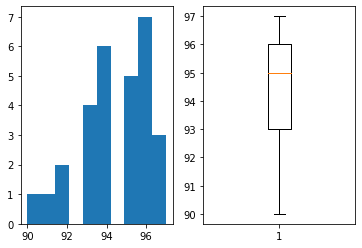

In [ ]:
hist_boxplot(data_stats.loc['max'])

The histogram shows an interval between values 92 to approximately 93. As well as there is an interval between values 94 and 95 approximately. On the side we see a greater concentration at 95.

## Analyzing Players Height

In [ ]:
data['Height'].head()

0     5'7
1     6'2
2     5'9
3     6'4
4    5'11
Name: Height, dtype: object

Here we can see that the heigth of players are object type but we required it into float type. 

So, we will convert the height into centimetres.

In [ ]:
data['Height'] = data['Height'].str.split('\'')
data['Height'] = [30.48 * int(elem[0]) + 2.54 * int(elem[1]) for elem in data['Height']]


In [ ]:
data['Height'].head()

0    170.18
1    187.96
2    175.26
3    193.04
4    180.34
Name: Height, dtype: float64

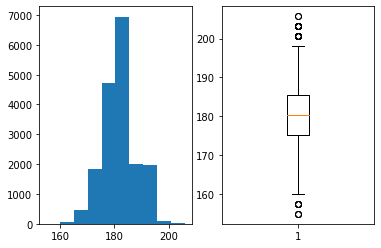

In [ ]:
hist_boxplot(data['Height'])


## Analyzing Players Weight

In [ ]:
data['Weight'].head()

0    159lbs
1    183lbs
2    150lbs
3    168lbs
4    154lbs
Name: Weight, dtype: object

Again we can see the weights of the player are object type but we want this data into float type.

So, we will convert the weight of the players from lbs to kilogram for easy understanding.

In [ ]:
data['Weight'] = data['Weight'].str.split('l')
data['Weight'] = [int(elem[0]) * 0.453 for elem in data['Weight']]

In [ ]:
data['Weight'].head()

0    72.027
1    82.899
2    67.950
3    76.104
4    69.762
Name: Weight, dtype: float64

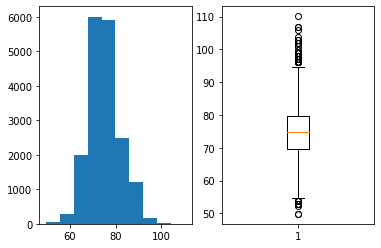

In [ ]:
# Checking Boxplot of weights
hist_boxplot(data['Weight'])

## Data Prepration

In [ ]:
position = np.array(data['Position'])
np.unique(position, return_counts = True)

(array(['CAM', 'CB', 'CDM', 'CF', 'CM', 'GK', 'LAM', 'LB', 'LCB', 'LCM',
        'LDM', 'LF', 'LM', 'LS', 'LW', 'LWB', 'RAM', 'RB', 'RCB', 'RCM',
        'RDM', 'RF', 'RM', 'RS', 'RW', 'RWB', 'ST'], dtype=object),
 array([ 958, 1778,  948,   74, 1394, 2025,   21, 1322,  648,  395,  243,
          15, 1095,  207,  381,   78,   21, 1291,  662,  391,  248,   16,
        1124,  203,  370,   87, 2152]))



Now we can delete the Position column from the database


In [ ]:
data = data.drop(['Position'], axis = 1)
data.head()

,Height,Weight,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,170.18,72.027,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0
1,187.96,82.899,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0
2,175.26,67.950,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0
3,193.04,76.104,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0
4,180.34,69.762,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0


In [ ]:
data.shape

(18147, 31)



We will now use a scale so that the values are between 0 and 1, we will do this because we will use KMeans to perform the grouping, as we can see the height has higher values than the Heading Accuracy, which affects the model. With that we will leave them in closer values for better results.


In [ ]:
scaler = MinMaxScaler()
train = scaler.fit_transform(data)
train

array([[0.3       , 0.36842105, 0.89772727, ..., 0.32967033, 0.28571429,
        0.26136364],
       [0.65      , 0.54887218, 0.89772727, ..., 0.27472527, 0.31868132,
        0.22727273],
       [0.4       , 0.30075188, 0.84090909, ..., 0.26373626, 0.24175824,
        0.34090909],
       ...,
       [0.35      , 0.28571429, 0.22727273, ..., 0.31868132, 0.12087912,
        0.09090909],
       [0.45      , 0.33082707, 0.44318182, ..., 0.18681319, 0.25274725,
        0.27272727],
       [0.45      , 0.4962406 , 0.40909091, ..., 0.40659341, 0.45054945,
        0.53409091]])

### Using the WCSS

In [ ]:
wcss = []
K = range(1, 12) #we have 11 players in a game
for k in K:
    KM = KMeans(n_clusters = k)
    KM = KM.fit(train)
    wcss.append(KM.inertia_)

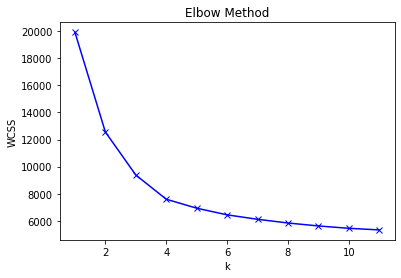

In [ ]:
plt.plot(K, wcss, 'bx-')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.title('Elbow Method');



Following the rule of the elbow method, we will choose number 4.

Now we will use the PCA:


In [ ]:
pca = PCA(n_components = 2)
data_pca = pca.fit_transform(train)
pca.explained_variance_ratio_
exp_var = [round(i, 1) for i in pca.explained_variance_ratio_ * 100]



Choosing the number of clusters with the silhouette method:

    Takes into account cohesion and separation
    Cohesion: measure of distance from one point to all other points in the same group
    Separation: measure the distance of a point with the points of the other clusters
    The coefficient is in the range of [-1, 1]
    The value -1 indicates that the cluster is bad (records in "wrong" groups)
    The value 0 indicates "indifference" (above the decision line, one cluster next to the other)
    The value 1 indicates that the clusters are far apart (the closer to 1, the better)



For n_clusters =  2  Average score:  0.4703559214248003
For n_clusters =  3  Average score:  0.28531924641304823
For n_clusters =  4  Average score:  0.27054139480884387
For n_clusters =  5  Average score:  0.24306126213389925
For n_clusters =  6  Average score:  0.21739504215318198
For n_clusters =  7  Average score:  0.20951371358872783
For n_clusters =  8  Average score:  0.2028098592076532
For n_clusters =  9  Average score:  0.18911808348455914
For n_clusters =  10  Average score:  0.1836586388597641
For n_clusters =  11  Average score:  0.17382798691862542


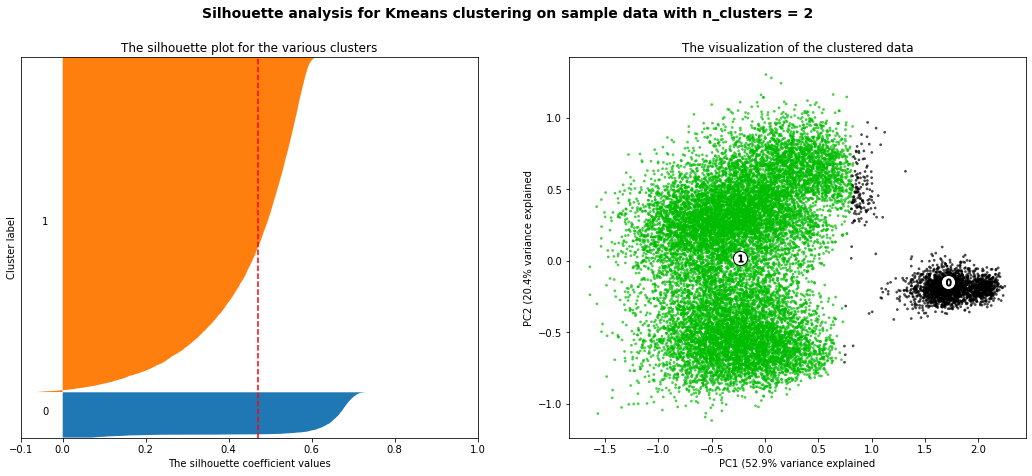

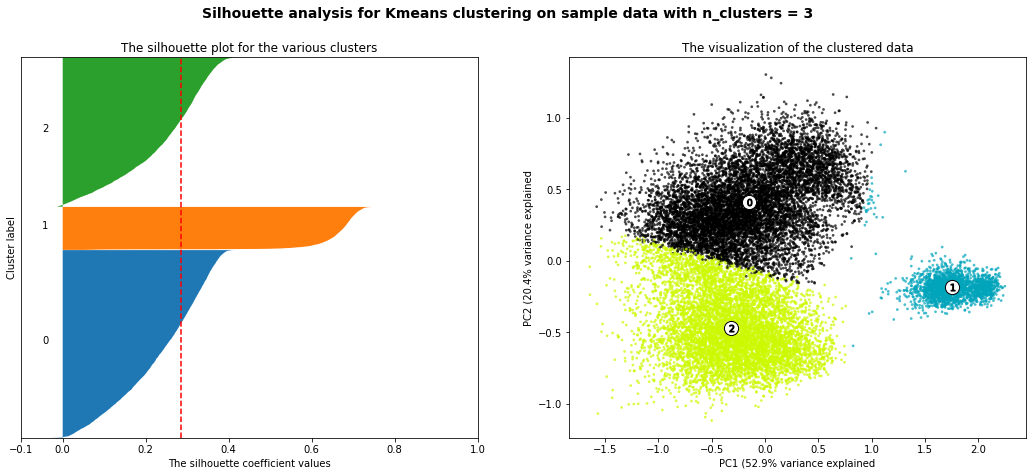

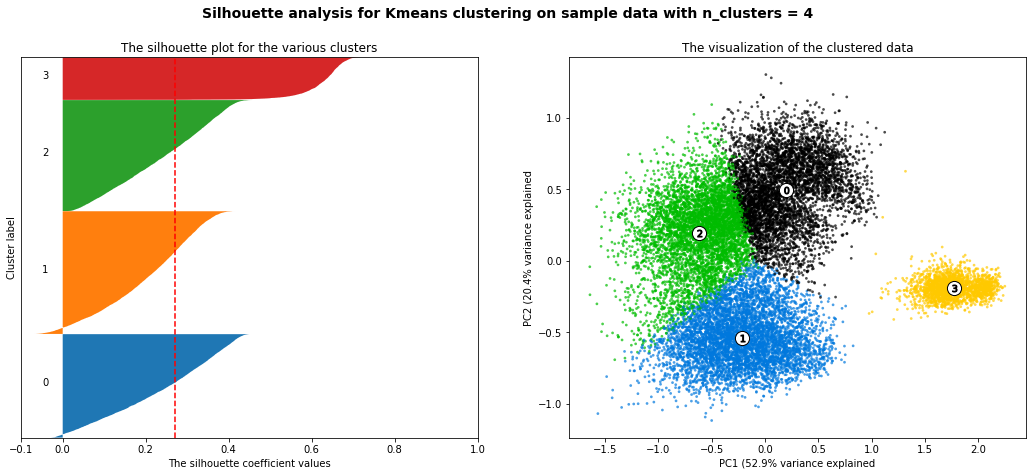

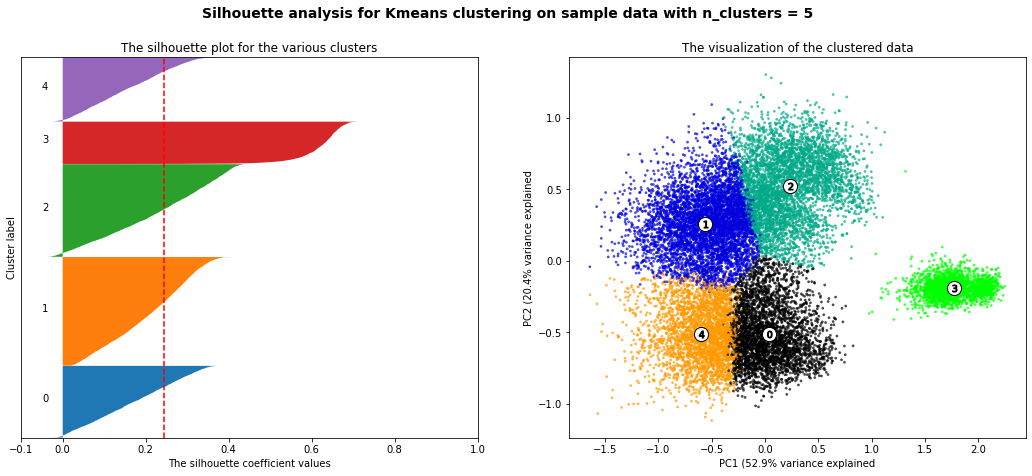

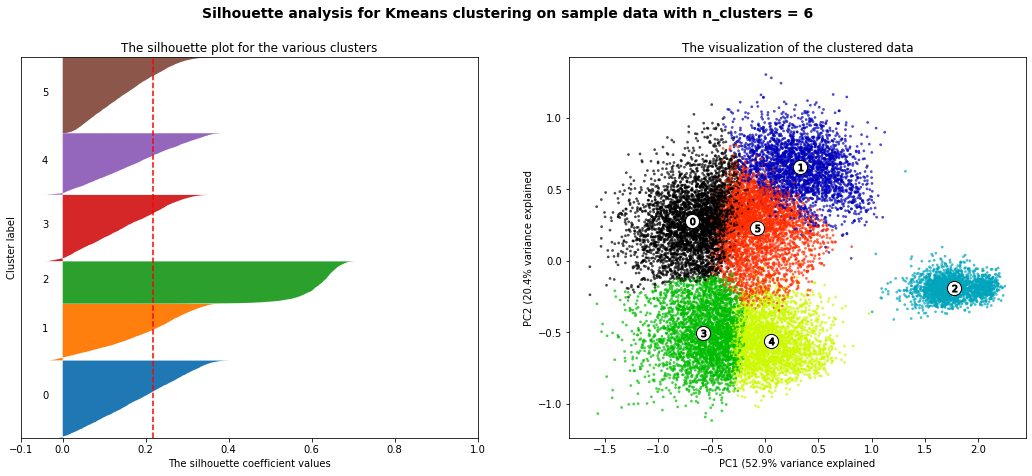

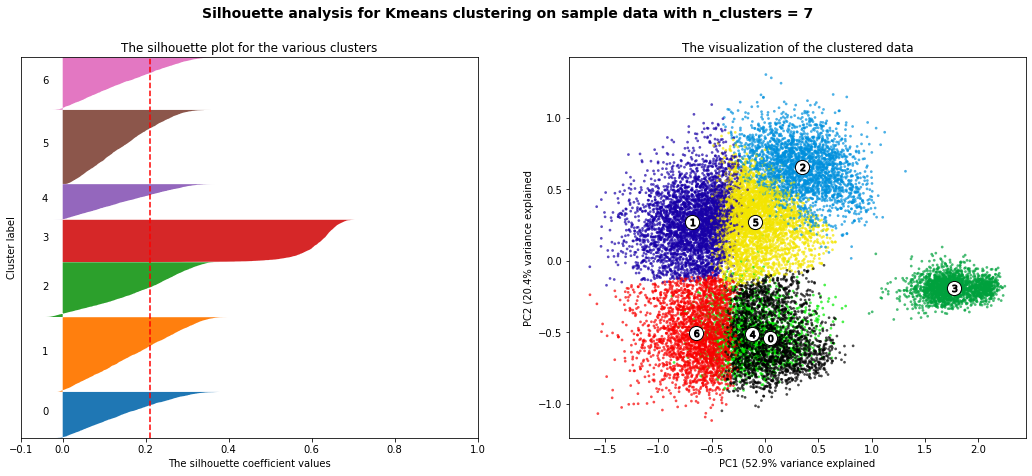

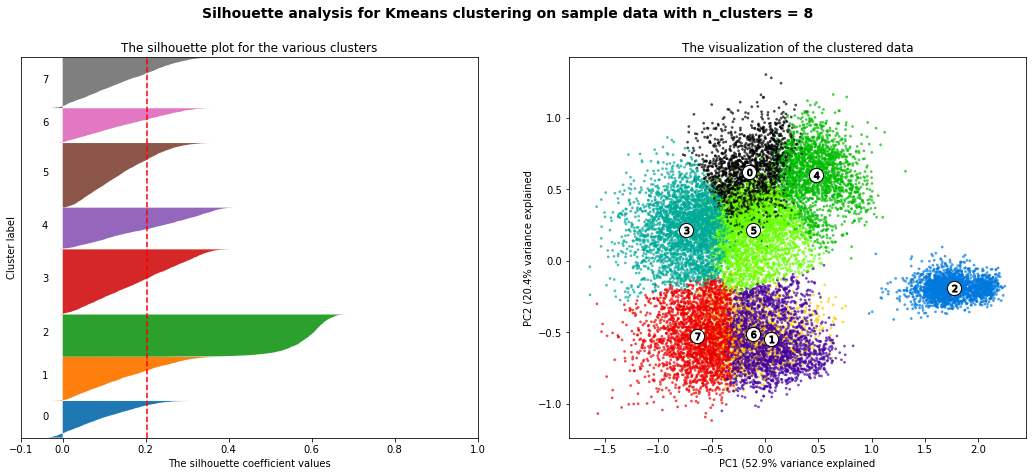

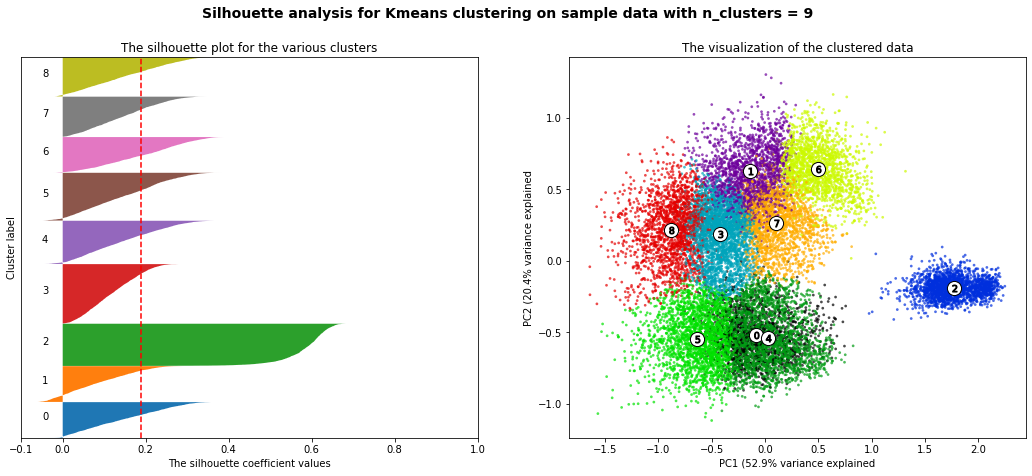

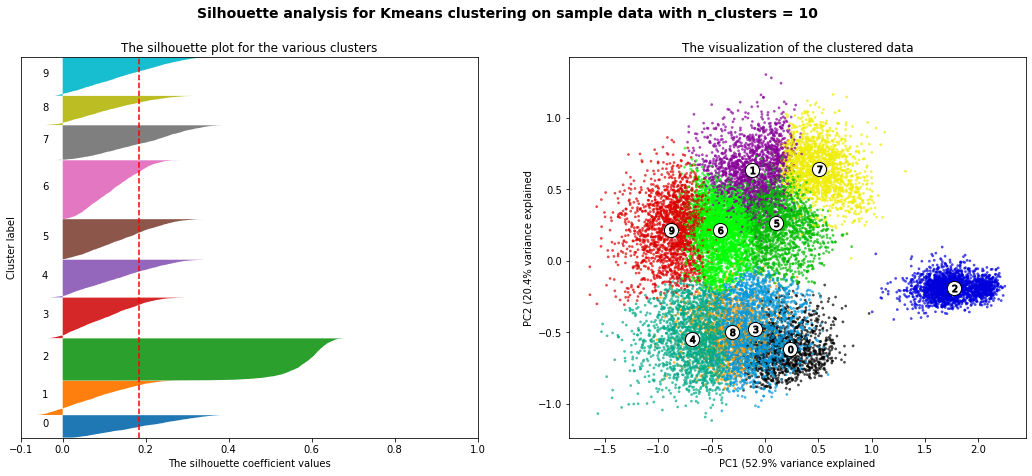

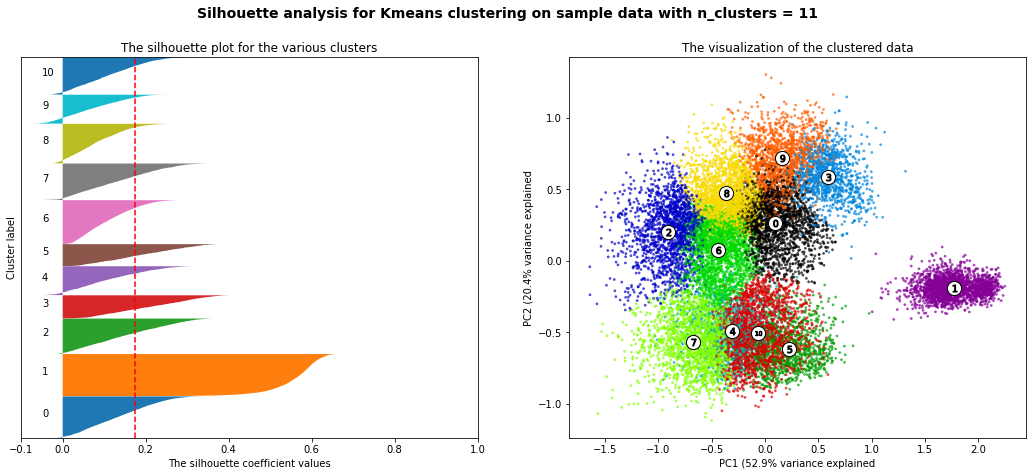

In [ ]:
range_n_clusters = range(2, 12)
for n_clusters in range_n_clusters:
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(18, 7)

  ax1.set_xlim([-0.1, 1])
  ax1.set_ylim([0, len(train) + (n_clusters + 1) * 10])

  clusterer = KMeans(n_clusters=n_clusters, random_state=10)
  cluster_labels = clusterer.fit_predict(train)
  #print(cluster_labels)
  #print(np.unique(cluster_labels))

  silhouette_avg = silhouette_score(train, cluster_labels)
  print("For n_clusters = ", n_clusters, " Average score: ", silhouette_avg)

  sample_silhouette_values = silhouette_samples(train, cluster_labels)
  #print(sample_silhouette_values)
  #print(len(sample_silhouette_values))

  y_lower = 10
  for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    #print(ith_cluster_silhouette_values.shape)

    size_cluster_i = ith_cluster_silhouette_values.shape[0]

    y_upper = y_lower + size_cluster_i
    #print(y_upper)
    
    ax1.fill_betweenx(np.arange(y_lower, y_upper), ith_cluster_silhouette_values)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10

  ax1.set_title("The silhouette plot for the various clusters")
  ax1.set_xlabel("The silhouette coefficient values")
  ax1.set_ylabel("Cluster label")   

  ax1.axvline(x = silhouette_avg, color = "red", linestyle = "--")

  ax1.set_yticks([])
  ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

  colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
  ax2.scatter(data_pca[:, 0], data_pca[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

  centers = clusterer.cluster_centers_
  centers = pca.transform(centers)
  ax2.scatter(centers[:, 0], centers[:,1], marker='o', c='white', alpha=1, s=200, edgecolor='k')

  for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, s=50, edgecolor='k')

  ax2.set_title("The visualization of the clustered data")
  ax2.set_xlabel('PC1 (' + str(exp_var[0]) + '% variance explained')
  ax2.set_ylabel('PC2 (' + str(exp_var[1]) + '% variance explained')

  plt.suptitle(("Silhouette analysis for Kmeans clustering on sample data with n_clusters = %d" % n_clusters),
               fontsize=14, fontweight='bold')

All passed the red line (which is the silhouette), the greater the number of clusters, the closer the cluetrs are, with more mixtures occurring and the groups passing less and less than the red line. The more you cross the red line, the more distributed the group is. For visualizations, the ideal number of clauster would be with the number 4 or 5. As we saw earlier, using the elbow method, the best was n_clusters = 4.

# K-Means Clustering

In [ ]:
km = KMeans(n_clusters = 4, n_init = 100, random_state = 0)
km.fit(train)

KMeans(n_clusters=4, n_init=100, random_state=0)

In [ ]:
print(km.cluster_centers_) #it shows the position of the centers

[[0.56041457 0.44624643 0.4458392  0.3136024  0.61720668 0.57810986
  0.31984583 0.4717723  0.34792761 0.34154837 0.49720889 0.53962922
  0.57418583 0.59154137 0.52116292 0.50156302 0.54101177 0.48259423
  0.65364762 0.62804387 0.66389867 0.34308979 0.62405965 0.65015908
  0.39667444 0.39148435 0.40764926 0.55574887 0.63779167 0.68143368
  0.67066494]
 [0.47913676 0.39687432 0.66659297 0.55061522 0.60001889 0.73035512
  0.55218721 0.6745819  0.62194766 0.5778198  0.67840277 0.7052998
  0.67329496 0.67672073 0.68473514 0.61726735 0.672568   0.69260189
  0.65926284 0.73937252 0.62990414 0.62896208 0.67789681 0.6862592
  0.63351695 0.64241639 0.57578304 0.67940172 0.65289961 0.69346181
  0.67430539]
 [0.65466206 0.53151997 0.10523837 0.10798309 0.11573754 0.23573043
  0.09783045 0.10612113 0.09896511 0.12593179 0.20004933 0.16441772
  0.30959691 0.31790471 0.3193654  0.50540372 0.33857918 0.22087305
  0.53352861 0.21978293 0.54510977 0.10621988 0.18329927 0.1580905
  0.09979789 0.32106444

In [ ]:
position[2]

'LW'

We will now make a comparison and see if the position of the player with the group in which he was harassed

In [ ]:
group = km.labels_ #will return in these records to which group it belongs (km.labels_)
comp = []
for i in range(0, len(position)):
    ele = tuple((position[i], group[i]))
    comp.append(ele)

In [ ]:
comp[0:4]

[('RF', 3), ('ST', 3), ('LW', 3), ('GK', 2)]

In [ ]:
#how many records per group
count = Counter(comp)
count

Counter({('CAM', 0): 18,
         ('CAM', 1): 279,
         ('CAM', 3): 661,
         ('CB', 0): 1621,
         ('CB', 1): 155,
         ('CB', 2): 1,
         ('CB', 3): 1,
         ('CDM', 0): 384,
         ('CDM', 1): 560,
         ('CDM', 3): 4,
         ('CF', 1): 6,
         ('CF', 3): 68,
         ('CM', 0): 325,
         ('CM', 1): 844,
         ('CM', 3): 225,
         ('GK', 0): 1,
         ('GK', 2): 2024,
         ('LAM', 1): 3,
         ('LAM', 3): 18,
         ('LB', 0): 595,
         ('LB', 1): 719,
         ('LB', 3): 8,
         ('LCB', 0): 533,
         ('LCB', 1): 114,
         ('LCB', 3): 1,
         ('LCM', 0): 31,
         ('LCM', 1): 308,
         ('LCM', 3): 56,
         ('LDM', 0): 47,
         ('LDM', 1): 190,
         ('LDM', 3): 6,
         ('LF', 1): 3,
         ('LF', 3): 12,
         ('LM', 0): 33,
         ('LM', 1): 257,
         ('LM', 3): 805,
         ('LS', 1): 15,
         ('LS', 3): 192,
         ('LW', 0): 2,
         ('LW', 1): 49,
         ('LW

In [ ]:
comp = pd.DataFrame({'Position': [i[0] for i in list(count.keys())],
                     'Group': [i[1] for i in list(count.keys())],
                     'Numbers': list(count.values())})

In [ ]:


comp.head()



,Position,Group,Numbers
0,RF,3,12
1,ST,3,2069
2,LW,3,330
3,GK,2,2024
4,RCM,1,323


In [ ]:
comp.shape

(77, 3)

In [ ]:
#ordering groups according to their position:
comp = comp.sort_values(['Position', 'Group'])
comp.head()

,Position,Group,Numbers
64,CAM,0,18
12,CAM,1,279
30,CAM,3,661
29,CB,0,1621
9,CB,1,155


In [ ]:
#analyzing in percentage
comp_per = pd.DataFrame()
pos = comp['Position'].unique()
pos

array(['CAM', 'CB', 'CDM', 'CF', 'CM', 'GK', 'LAM', 'LB', 'LCB', 'LCM',
       'LDM', 'LF', 'LM', 'LS', 'LW', 'LWB', 'RAM', 'RB', 'RCB', 'RCM',
       'RDM', 'RF', 'RM', 'RS', 'RW', 'RWB', 'ST'], dtype=object)

In [ ]:
for p in pos:
    comp_p = comp[comp['Position'] == p] 
    sum_N = sum(comp_p['Numbers'])
    comp_p['Numbers'] = comp_p['Numbers'] / sum_N
    comp_per = comp_per.append(comp_p)
comp_per = comp_per.sort_values(['Group', 'Numbers', 'Position'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
comp_per.head()

,Position,Group,Numbers
70,GK,0,0.000494
68,RW,0,0.002703
63,ST,0,0.004647
69,RS,0,0.004926
73,LW,0,0.005249


In [ ]:
comp_per.tail()

,Position,Group,Numbers
32,RW,3,0.878378
37,CF,3,0.918919
22,LS,3,0.927536
34,RS,3,0.940887
1,ST,3,0.961431


In [ ]:
#let's create a bar graph with the percentage of frequencies for each group:

comp_barplot = pd.DataFrame({'Position': sum([[ele] * 4 for ele in np.unique(position)], []),
                             'Group': sum([['0', '1', '2', '3'] * len(np.unique(position))], []),
                             'Numbers': [0] * 4 * len(np.unique(position))})

In [ ]:
comp_barplot.head(10)

,Position,Group,Numbers
0,CAM,0,0
1,CAM,1,0
2,CAM,2,0
3,CAM,3,0
4,CB,0,0
5,CB,1,0
6,CB,2,0
7,CB,3,0
8,CDM,0,0
9,CDM,1,0


In [ ]:
#we will now find the value of 'Numbers':

for row in range(0, len(comp_barplot)):
    pos = comp_barplot.iloc[row, 0]
    gro = int(comp_barplot.iloc[row, 1])
    reg = comp_per.loc[(comp_per['Position'] == pos) & (comp_per['Group'] == gro), :]
if len(reg) > 0:
    comp_barplot.iloc[row, 2] = reg['Numbers'].values

In [ ]:
comp_barplot.head()

,Position,Group,Numbers
0,CAM,0,0.0
1,CAM,1,0.0
2,CAM,2,0.0
3,CAM,3,0.0
4,CB,0,0.0


In [ ]:
counter1 = Counter(comp_per[comp_per['Numbers'] >= 0.5]['Group'])
counter1

Counter({0: 3, 1: 10, 2: 1, 3: 13})

In [ ]:
#for security and warranty, we will leave this ordering code
counter1 = dict(sorted(counter1.items(), key = lambda x: x[0]))
counter1

{0: 3, 1: 10, 2: 1, 3: 13}

In [ ]:
x = [str(ele) for ele in list(counter1.keys())]
x

['0', '1', '2', '3']

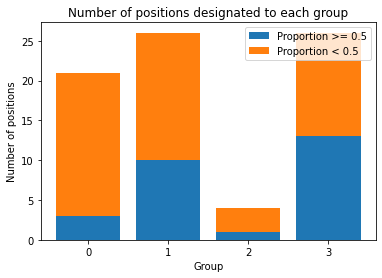

In [ ]:


p1 = plt.bar(x, counter1.values())
counter2 = Counter(comp_per[comp_per['Numbers'] < 0.5]['Group'])
counter2 = dict(sorted(counter2.items(), key = lambda x: x[0]))
x = [str(ele) for ele in list(counter2.keys())]

p2 = plt.bar(x, counter2.values(), bottom=list(counter1.values()))
plt.title('Number of positions designated to each group')
plt.xlabel('Group')
plt.ylabel('Number of positions')
plt.legend((p1[0], p2[0]), ('Proportion >= 0.5', 'Proportion < 0.5'))



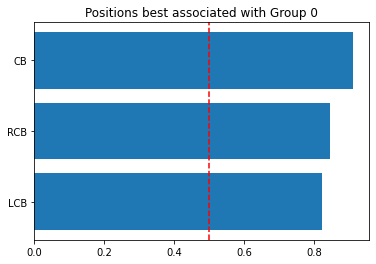

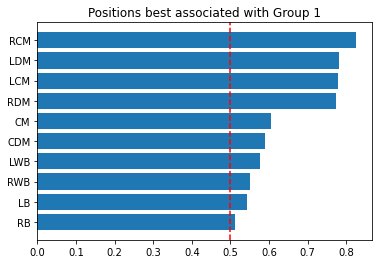

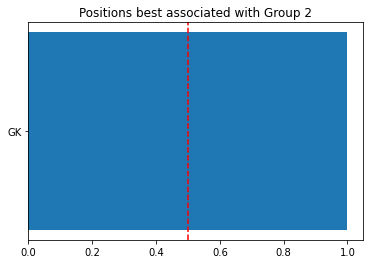

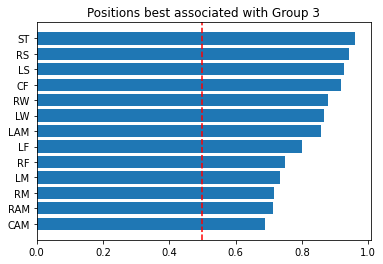

In [ ]:
#most frequent positions for each group:
for i in range(4):
    g = comp_per[(comp_per['Group'] == i) & (comp_per['Numbers'] >= 0.5)][['Position', 'Numbers']]
    g = g.sort_values(by = 'Numbers')
    plt.barh(g['Position'], g['Numbers'])
    plt.axvline(0.5, color = 'r', linestyle = '--')
    plt.title('Positions best associated with Group ' + str(i))
    plt.show()